# What is LangSmith?

**LangSmith** is a unified observability and evaluation platform where teams can debug, test, and monitor AI application performance.

---

# What is Observability?

**Observability** is the ability to understand a system's internal state by examining its external outputs, such as logs, metrics, and traces.

It allows you to:

- Diagnose issues  
- Understand performance  
- Improve reliability  

by analyzing data generated by the system.

Essentially, it helps answer the question:

> "Why is something happening inside the system?"

Even if you did not anticipate the problem.

---

# What Does LangSmith Trace?

LangSmith traces the following:

1. **Input and Output**
2. **All intermediate steps**
3. **Latency**
4. **Token usage**
5. **Cost**
6. **Errors**
7. **Tags**
8. **Metadata**
9. **Feedback**

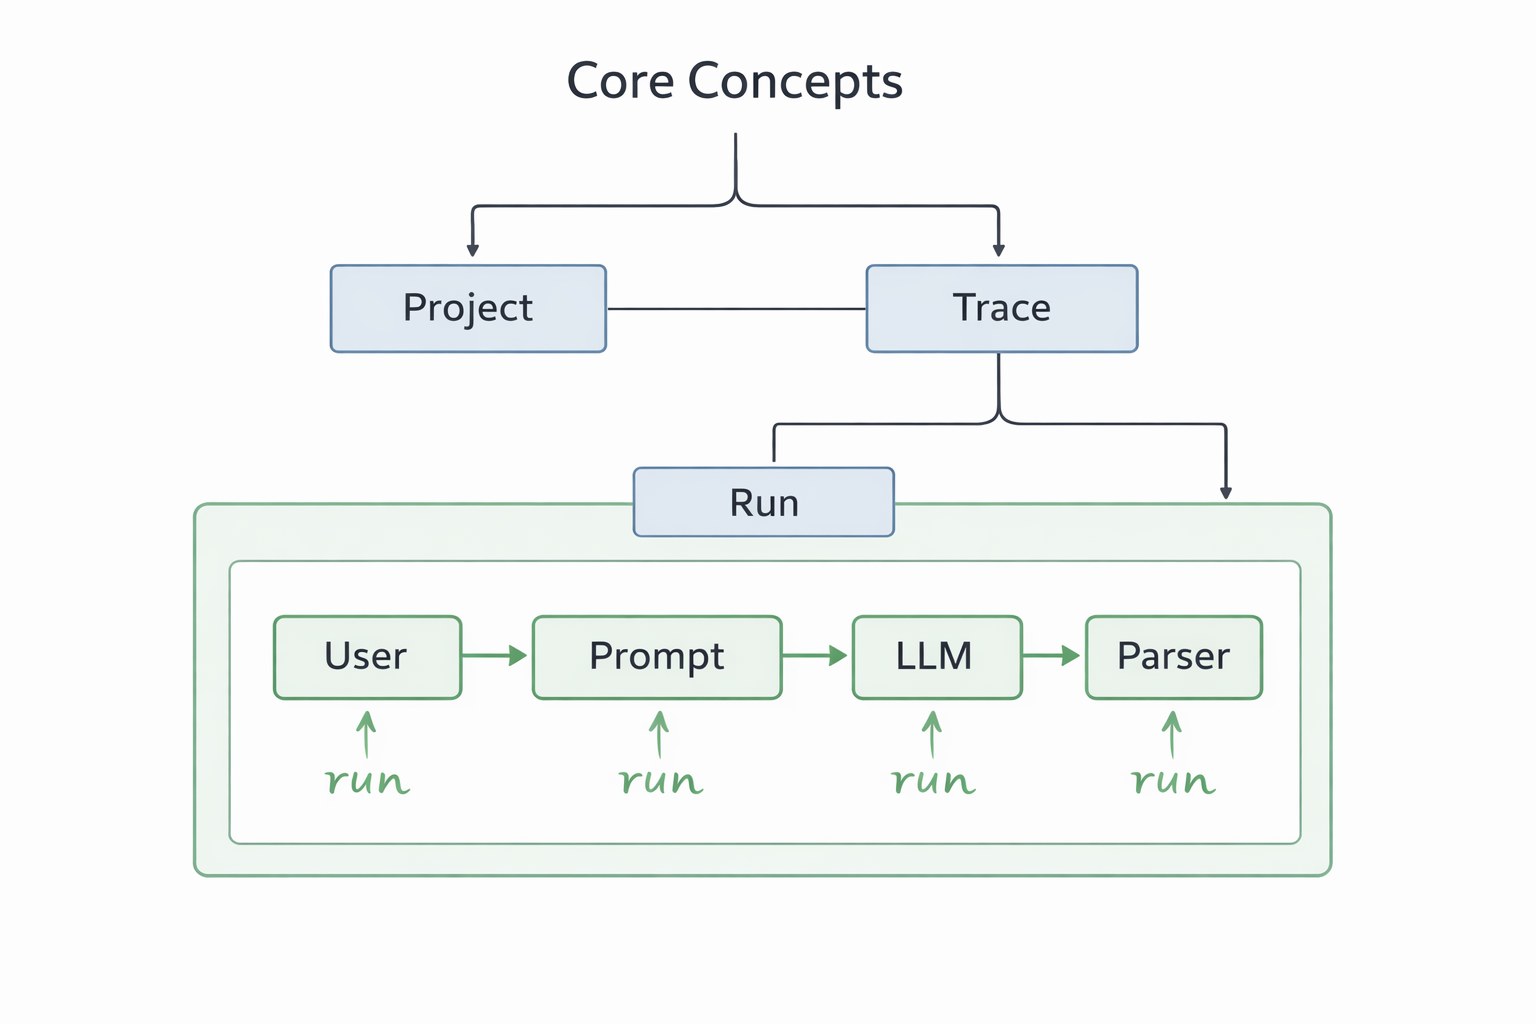

# 1 => Simple LLM Call

In [ ]:
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

# Step 1: Create endpoint LLM
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    temperature=0.7,
    max_new_tokens=512,
)

# Step 2: Wrap it as Chat model
model = ChatHuggingFace(llm=llm)

# Step 3: Chat prompt
prompt = ChatPromptTemplate.from_template("{question}")

parser = StrOutputParser()

chain = prompt | model | parser

result = chain.invoke({
    "question": "What is the use of LangSmith in LangChain and LangGraph?"
})

print(result)


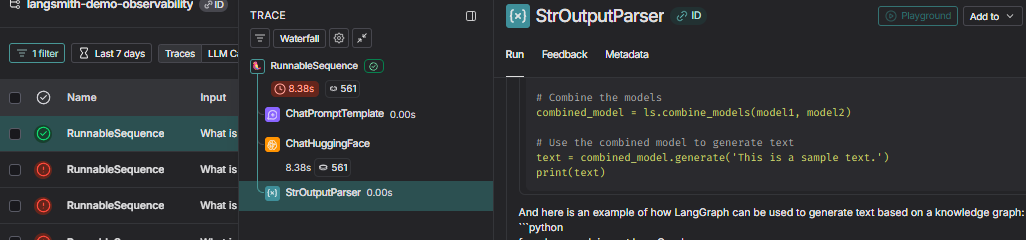

# 2 => Sequential Chain

In [ ]:
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# os.environ["LANGCHAIN_PROJECT"] = "SEQ_CHAIN_TESTING"

load_dotenv()

# Step 1: Base LLM endpoint
llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    temperature=0.7,
    max_new_tokens=1024,
)

# Step 2: Wrap as chat model
model = ChatHuggingFace(llm=llm)

# Step 3: Chat prompts
prompt1 = ChatPromptTemplate.from_template(
    "Generate a detailed report on {topic}"
)

prompt2 = ChatPromptTemplate.from_template(
    "Generate a 5 pointer summary from the following text:\n{text}"
)

parser = StrOutputParser()

# Step 4: Chain
chain = prompt1 | model | parser | prompt2 | model | parser

config = {
    'run_name': 'sequential_chain',
    'tags': ['llm app', 'report generation', 'summarization'],
    'metadata': {'model1': 'Meta-Llama-3-8B-Instruct', 'model1_temp' :0.7, 'parser': 'stroutputparser'}
}

# Step 5: Run
result = chain.invoke({"topic": "Semiconductor industry trends in 2025"}, config=config)

print(result)


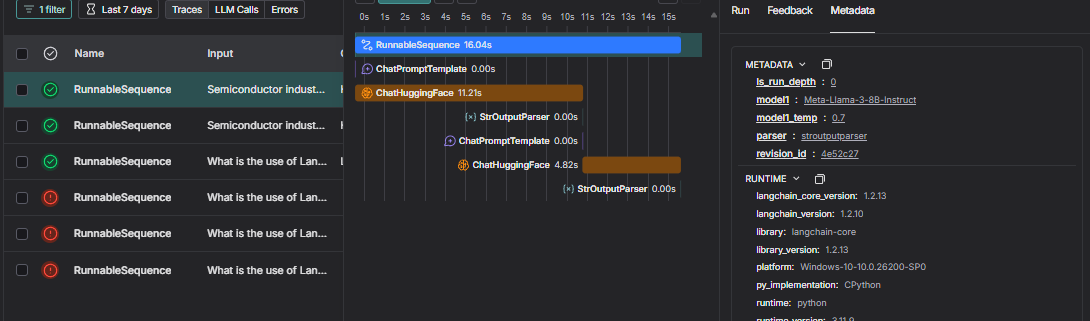

# 3 => RAG test 1

## RAG Apps – Failure Modes

### 1️⃣ Retriever Errors
Wrong or irrelevant documents retrieved.

### 2️⃣ Generator Errors
Model hallucinates or misuses context.

---

### 🚨 Production Challenge
In production, it's often unclear where the failure happened.  
Was the retriever bad?  
Or did the LLM ignore the documents?

---

### 📊 LangSmith Automatically Records
- User query  
- Retrieved documents  
- LLM prompt (with inserted docs)  
- LLM response


In [ ]:
import os
from dotenv import load_dotenv

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

from langchain_huggingface import (
    HuggingFaceEndpoint,
    ChatHuggingFace,
    HuggingFaceEmbeddings,
)

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import (
    RunnableParallel,
    RunnablePassthrough,
    RunnableLambda,
)
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
if not HF_TOKEN:
    raise ValueError("Set HUGGINGFACEHUB_API_TOKEN in .env file")

# Load PDF

PDF_PATH = "advs.pdf"

loader = PyPDFLoader(PDF_PATH)
docs = loader.load()

# Split into chunks

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
)
splits = splitter.split_documents(docs)

# Embeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)

# Chroma Vector Store

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory="./chroma_db",  # Saves DB locally
)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 7},
)

# HuggingFace LLM

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    temperature=0.7,
    max_new_tokens=512,
)
llm = ChatHuggingFace(llm=hf_llm)

# Prompt

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "Answer ONLY from the provided context. "
        "If the answer is not found in the context, say 'I don't know.'"
    ),
    (
        "human",
        "Question: {question}\n\nContext:\n{context}"
    ),
])


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG Chain

rag_chain = (
    RunnableParallel(
        {
            "context": retriever | RunnableLambda(format_docs),
            "question": RunnablePassthrough(),
        }
    )
    | prompt
    | llm
    | StrOutputParser()
)

print("PDF RAG ready. Ask a question (Ctrl+C to exit).") 
q = input("\nQ: ") 
answer = rag_chain.invoke(q.strip()) 
print("\nA:", answer)

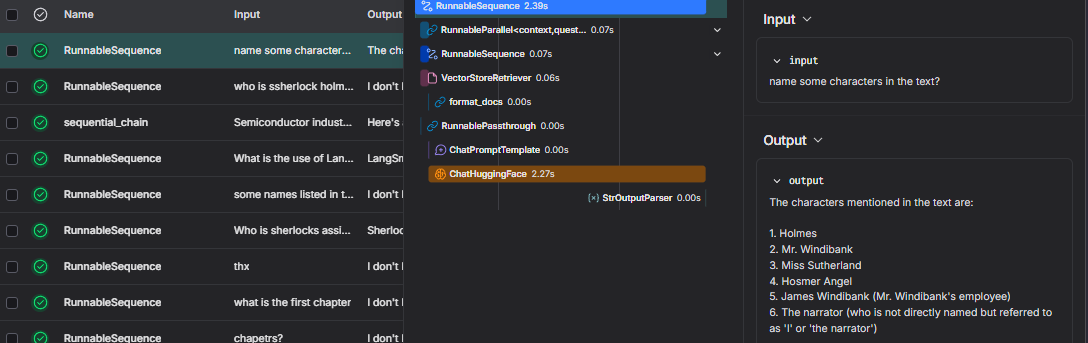

# 4 => RAG test 2

In [ ]:
# pip install -U langchain langchain-openai langchain-community chromadb pypdf python-dotenv langsmith huggingface_hub sentence-transformers

import os
from dotenv import load_dotenv

from langsmith import traceable  # <-- key import

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# --- LangSmith env (make sure these are set) ---
# LANGCHAIN_TRACING_V2=true
# LANGCHAIN_API_KEY=...
# LANGCHAIN_PROJECT=pdf_rag_demo

load_dotenv()

PDF_PATH = "advs.pdf"  

# ---------- traced setup steps ----------
@traceable(name="load_pdf")
def load_pdf(path: str):
    loader = PyPDFLoader(path)
    return loader.load()  # list[Document]

@traceable(name="split_documents")
def split_documents(docs, chunk_size=1000, chunk_overlap=150):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(docs)

@traceable(name="build_vectorstore")
def build_vectorstore(splits):
    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vs = Chroma.from_documents(
        documents=splits,
        embedding=emb
    )
    return vs

# You can also trace a “setup” umbrella span if you want:
@traceable(name="setup_pipeline")
def setup_pipeline(pdf_path: str):
    docs = load_pdf(pdf_path)
    splits = split_documents(docs)
    vs = build_vectorstore(splits)
    return vs

# ---------- pipeline ----------
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    task="conversational",
    temperature=0,
    max_new_tokens=512,
)
llm = ChatHuggingFace(llm=hf_llm)

prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer ONLY from the provided context. If not found, say you don't know."),
    ("human", "Question: {question}\n\nContext:\n{context}")
])

def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)

# Build the index under traced setup
vectorstore = setup_pipeline(PDF_PATH)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

parallel = RunnableParallel({
    "context": retriever | RunnableLambda(format_docs),
    "question": RunnablePassthrough(),
})

chain = parallel | prompt | llm | StrOutputParser()

# ---------- run a query (also traced) ----------
print("PDF RAG ready. Ask a question (or Ctrl+C to exit).")
q = input("\nQ: ").strip()

# Give the visible run name + tags/metadata so it’s easy to find:
config = {
    "run_name": "pdf_rag_query"
}

ans = chain.invoke(q, config=config)
print("\nA:", ans)


-Individual rag components:
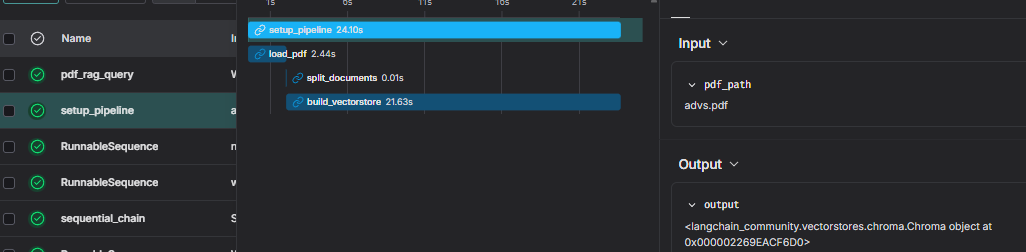

-Overall build:
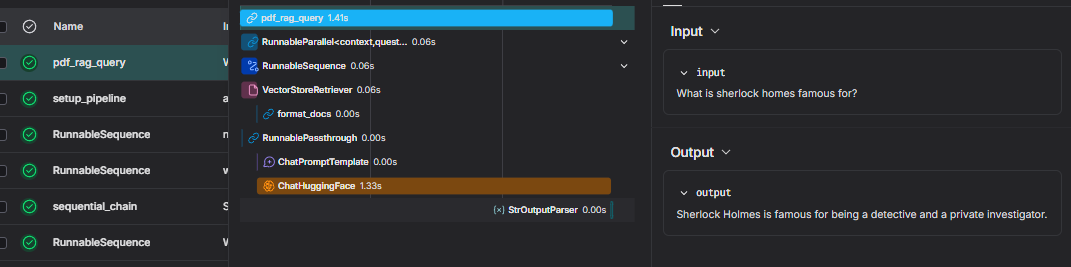


# 5 => RAG test 3

In [ ]:
# pip install -U langchain langchain-huggingface langchain-community chromadb pypdf python-dotenv langsmith sentence-transformers huggingface_hub

import os
from dotenv import load_dotenv

from langsmith import traceable

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

PDF_PATH = "advs.pdf"  

# ----------------- helpers (not traced individually) -----------------
@traceable(name="load_pdf",tags=["setup","pdf","loader"],metadata={"version": "1.0","loader": "PyPDFLoader"})
def load_pdf(path: str):
    loader = PyPDFLoader(path)
    return loader.load()  # list[Document]

@traceable(name="split_documents", tags=["setup","splitting"])
def split_documents(docs, chunk_size=1000, chunk_overlap=150):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(docs)

@traceable(name="build_vectorstore", tags=["setup","vectorstore"])
def build_vectorstore(splits):
    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return Chroma.from_documents(
        documents=splits,
        embedding=emb
    )

# ----------------- parent setup function (traced) -----------------
@traceable(name="setup_pipeline", tags=["setup"])
def setup_pipeline(pdf_path: str, chunk_size=1000, chunk_overlap=150):
    docs = load_pdf(pdf_path)
    splits = split_documents(docs, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    vs = build_vectorstore(splits)
    return vs

# ----------------- model, prompt, and run -----------------
hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    task="conversational",
    temperature=0,
    max_new_tokens=512,
)
llm = ChatHuggingFace(llm=hf_llm)

prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer ONLY from the provided context. If not found, say you don't know."),
    ("human", "Question: {question}\n\nContext:\n{context}")
])

def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)

# ----------------- one top-level (root) run -----------------
@traceable(name="pdf_rag_full_run")
def setup_pipeline_and_query(pdf_path: str, question: str):
    vectorstore = setup_pipeline(pdf_path, chunk_size=1000, chunk_overlap=150)

    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

    parallel = RunnableParallel({
        "context": retriever | RunnableLambda(format_docs),
        "question": RunnablePassthrough(),
    })

    chain = parallel | prompt | llm | StrOutputParser()

    lc_config = {"run_name": "pdf_rag_query"}
    return chain.invoke(question, config=lc_config)

# ----------------- CLI -----------------
if __name__ == "__main__":
    print("PDF RAG ready. Ask a question (or Ctrl+C to exit).")
    q = input("\nQ: ").strip()
    ans = setup_pipeline_and_query(PDF_PATH, q)
    print("\nA:", ans)


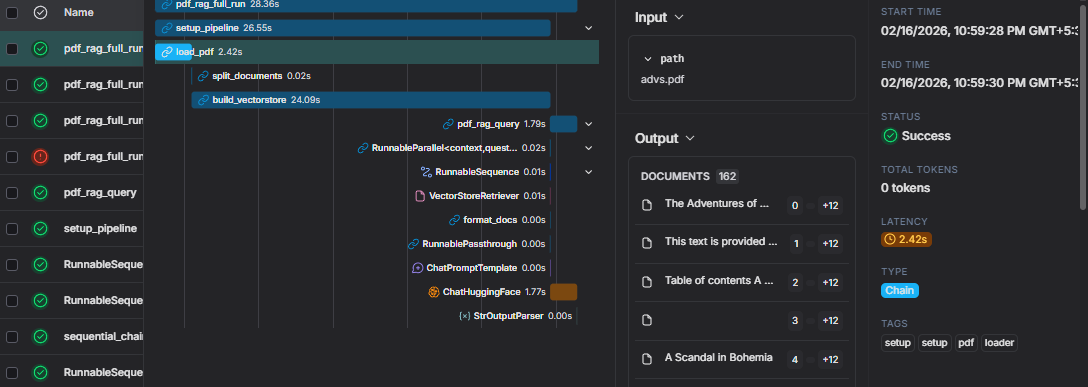

# 6 => RAG test 4

In [ ]:
# pip install -U langchain langchain-openai langchain-community chromadb pypdf python-dotenv langsmith

import os
import json
import hashlib
from pathlib import Path
from dotenv import load_dotenv

from langsmith import traceable

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

PDF_PATH = "advs.pdf" 
INDEX_ROOT = Path(".indices")
INDEX_ROOT.mkdir(exist_ok=True)

# ----------------- helpers (traced) -----------------
@traceable(name="load_pdf")
def load_pdf(path: str):
    return PyPDFLoader(path).load()  # list[Document]

@traceable(name="split_documents")
def split_documents(docs, chunk_size=1000, chunk_overlap=150):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )
    return splitter.split_documents(docs)

@traceable(name="build_vectorstore")
def build_vectorstore(splits, embed_model_name: str, index_dir: Path):
    emb = HuggingFaceEmbeddings(model_name=embed_model_name)
    vs = Chroma.from_documents(
        documents=splits,
        embedding=emb,
        persist_directory=str(index_dir)
    )
    index_dir.mkdir(parents=True, exist_ok=True)
    vs.persist()  # ✅ correct usage
    return vs

# ----------------- cache key / fingerprint -----------------
def _file_fingerprint(path: str) -> dict:
    p = Path(path)
    h = hashlib.sha256()
    with p.open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return {"sha256": h.hexdigest(), "size": p.stat().st_size, "mtime": int(p.stat().st_mtime)}

def _index_key(pdf_path: str, chunk_size: int, chunk_overlap: int, embed_model_name: str) -> str:
    meta = {
        "pdf_fingerprint": _file_fingerprint(pdf_path),
        "chunk_size": chunk_size,
        "chunk_overlap": chunk_overlap,
        "embedding_model": embed_model_name,
        "format": "v1",
    }
    return hashlib.sha256(json.dumps(meta, sort_keys=True).encode("utf-8")).hexdigest()

# ----------------- explicitly traced load/build runs -----------------
@traceable(name="load_index", tags=["index"])
def load_index_run(index_dir: Path, embed_model_name: str):
    emb = HuggingFaceEmbeddings(model_name=embed_model_name)
    return Chroma(persist_directory=str(index_dir), embedding_function=emb)

@traceable(name="build_index", tags=["index"])
def build_index_run(pdf_path: str, index_dir: Path, chunk_size: int, chunk_overlap: int, embed_model_name: str):
    docs = load_pdf(pdf_path)
    splits = split_documents(docs, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    vs = build_vectorstore(splits, embed_model_name, index_dir)
    (index_dir / "meta.json").write_text(json.dumps({
        "pdf_path": os.path.abspath(pdf_path),
        "chunk_size": chunk_size,
        "chunk_overlap": chunk_overlap,
        "embedding_model": embed_model_name,
    }, indent=2))
    return vs

# ----------------- dispatcher -----------------
def load_or_build_index(
    pdf_path: str,
    chunk_size: int = 1000,
    chunk_overlap: int = 150,
    embed_model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
    force_rebuild: bool = False,
):
    key = _index_key(pdf_path, chunk_size, chunk_overlap, embed_model_name)
    index_dir = INDEX_ROOT / key
    cache_hit = index_dir.exists() and not force_rebuild
    if cache_hit:
        return load_index_run(index_dir, embed_model_name)
    else:
        return build_index_run(pdf_path, index_dir, chunk_size, chunk_overlap, embed_model_name)

# ----------------- model, prompt, and pipeline -----------------
hf_llm_endpoint = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    task="conversational",
    temperature=0,
    max_new_tokens=512
)
llm = ChatHuggingFace(llm=hf_llm_endpoint)

prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer ONLY from the provided context. If not found, say you don't know."),
    ("human", "Question: {question}\n\nContext:\n{context}")
])

def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)

@traceable(name="setup_pipeline", tags=["setup"])
def setup_pipeline(pdf_path: str, chunk_size=1000, chunk_overlap=150, embed_model_name="sentence-transformers/all-MiniLM-L6-v2", force_rebuild=False):
    return load_or_build_index(
        pdf_path=pdf_path,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        embed_model_name=embed_model_name,
        force_rebuild=force_rebuild
    )

@traceable(name="pdf_rag_full_run")
def setup_pipeline_and_query(
    pdf_path: str,
    question: str,
    chunk_size: int = 1000,
    chunk_overlap: int = 150,
    embed_model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
    force_rebuild: bool = False,
):
    vectorstore = setup_pipeline(pdf_path, chunk_size, chunk_overlap, embed_model_name, force_rebuild)
    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

    parallel = RunnableParallel({
        "context": retriever | RunnableLambda(format_docs),
        "question": RunnablePassthrough(),
    })
    chain = parallel | prompt | llm | StrOutputParser()

    return chain.invoke(
        question,
        config={"run_name": "pdf_rag_query", "tags": ["qa"], "metadata": {"k": 4}}
    )

# ----------------- CLI -----------------
if __name__ == "__main__":
    print("PDF RAG ready. Ask a question (or Ctrl+C to exit).")
    q = input("\nQ: ").strip()
    ans = setup_pipeline_and_query(PDF_PATH, q)
    print("\nA:", ans)


-First run to build index:
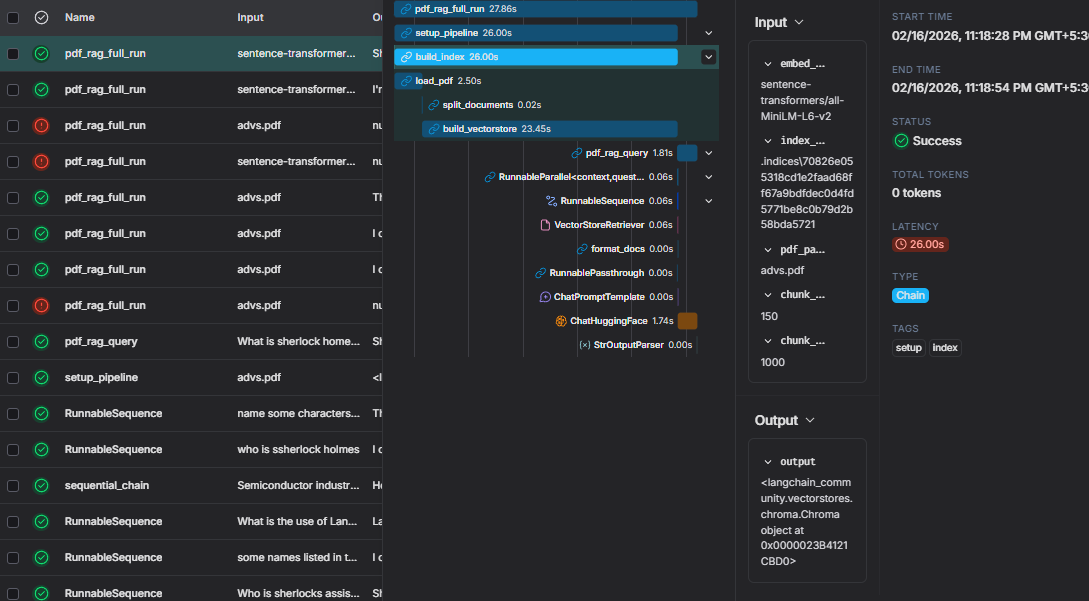

-Nxt run fetches index from prev one:
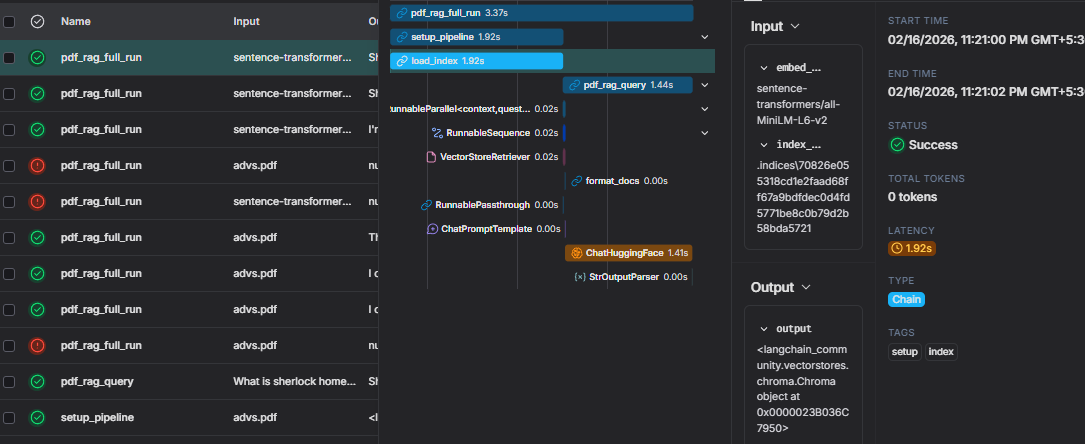

-Triggers the build path in exactly these cases:

 - **No cache exists yet means First-ever run**
 - **PDF content changes.**
 - **PDF file metadata (for e.g. size) changes.**
 - **Chunking params change > chunk size or chunk overlap.**
 - **Embedding model name changes to another model.**

# 7 => Agentic testing

In [28]:
# ----------------- imports -----------------
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_classic.agents import create_react_agent, AgentExecutor
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
import requests

load_dotenv()

# ----------------- Tools -----------------
# DuckDuckGo search tool
search_tool = DuckDuckGoSearchRun()

# Weather tool
@tool
def get_weather_data(city: str) -> str:
    """
    Fetches the current weather data for a given city.
    """
    url = f'https://api.weatherstack.com/current?access_key=25d88950bded96fe832804fec6dcd00a&query={city}'
    response = requests.get(url)
    data = response.json()
    
    if "current" in data:
        temp = data["current"].get("temperature", "N/A")
        desc = data["current"].get("weather_descriptions", ["N/A"])[0]
        return f"Temperature: {temp}°C, Condition: {desc}"
    elif "error" in data:
        return f"Error: {data['error'].get('info', 'Unknown error')}"
    else:
        return "No weather data available."

# ----------------- LLM -----------------
hf_llm_endpoint = HuggingFaceEndpoint(
    repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
    task="conversational",
    temperature=0,
    max_new_tokens=512
)

llm = ChatHuggingFace(llm=hf_llm_endpoint)

# ----------------- Prompt -----------------
# Strict ReAct prompt with clear instructions
react_prompt = PromptTemplate(
    input_variables=["input", "tools", "tool_names", "agent_scratchpad"],
    template="""
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
"""
)

# ----------------- Agent -----------------
agent = create_react_agent(
    llm=llm,
    tools=[search_tool, get_weather_data],
    prompt=react_prompt
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=[search_tool, get_weather_data],
    verbose=True,
    max_iterations=10,
    handle_parsing_errors=True  # <-- retry automatically if parser fails
)

# ----------------- Run -----------------
# query = "What is the current temperature of Gurgaon?"
query = "Identify the birthplace of Dr.A.P.J.Abdul Kalam (search) and get the current temperature of that place ?"
response = agent_executor.invoke({"input": query})

print(response)  # Full response object
print("\nAnswer:", response.get("output"))  # Clean answer text




> Entering new AgentExecutor chain...
Thought: I need to find the birthplace of Dr. A.P.J. Abdul Kalam, which is a piece of information that can be searched online. 
Action: duckduckgo_search
Action Input: Dr.A.P.J.Abdul Kalam birthplace
Observ2 days ago - In 2015, the Government of Tamil Nadu announced that Kalam's birthday, 15 October, would be observed as "Youth Renaissance Day". It also instituted the "Dr. A. P. J. Abdul Kalam Award" constituting a gold medal, a certificate and ₹500,000 (US$5,900), to be awarded annually on the Indian ... 1 week ago - Kalam's birth date which is on 15 October, the commencement of construction on a memorial at Rameswaram was publicized by Prime Minister Narendra Modi. On 27 July 2017, on the occasion of Dr. 19 November 2025 - A. P. J. Abdul Kalam was an Indian aerospace scientist and statesman who served as president of India from 2002 to 2007. Born in Rameswaram in Southern India , Kalam spent four decades as a scientist and science administrator

- Single prompt: 
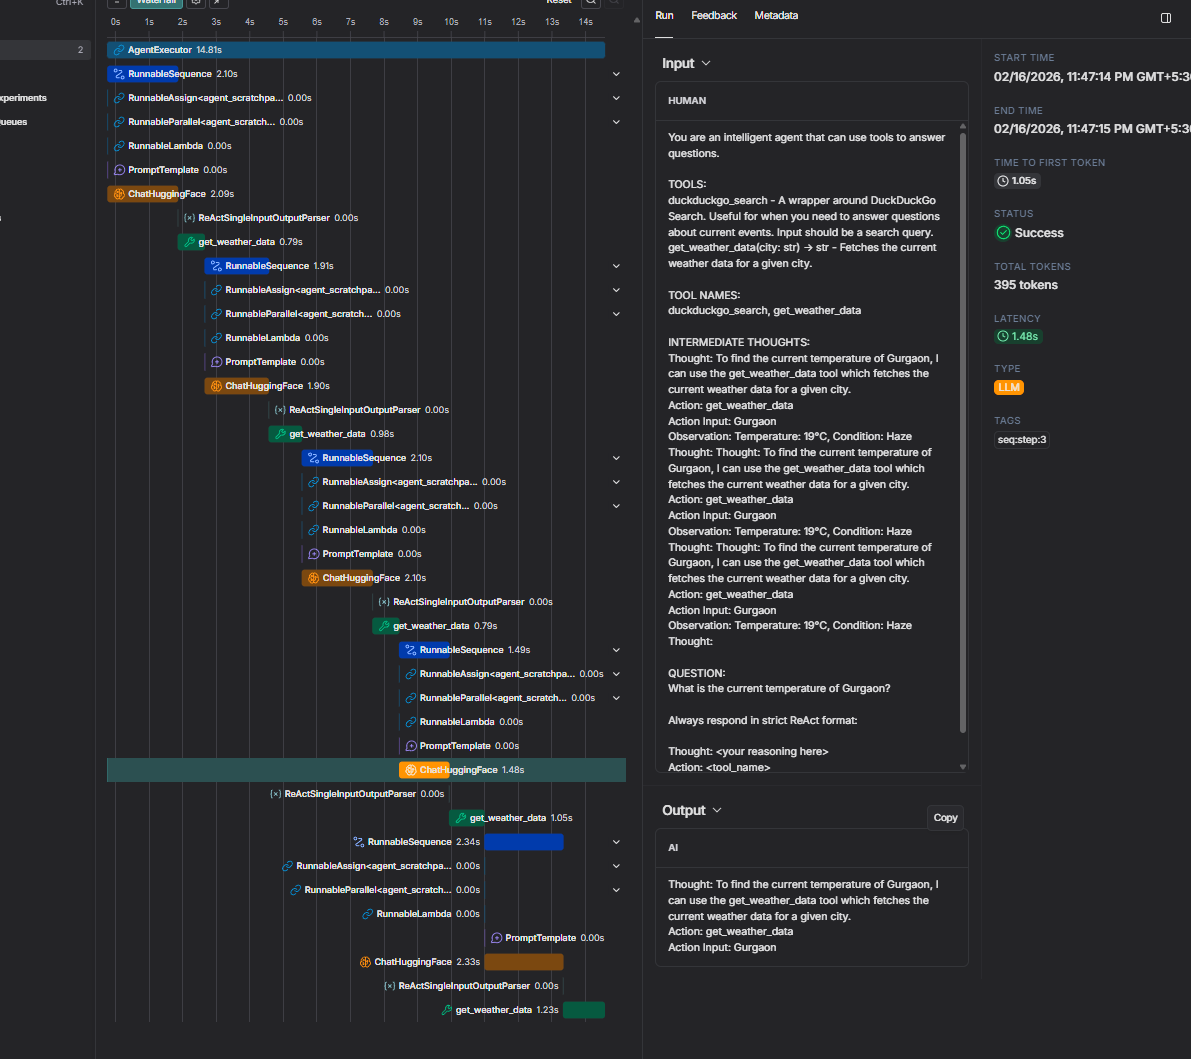

-Chained prompt :
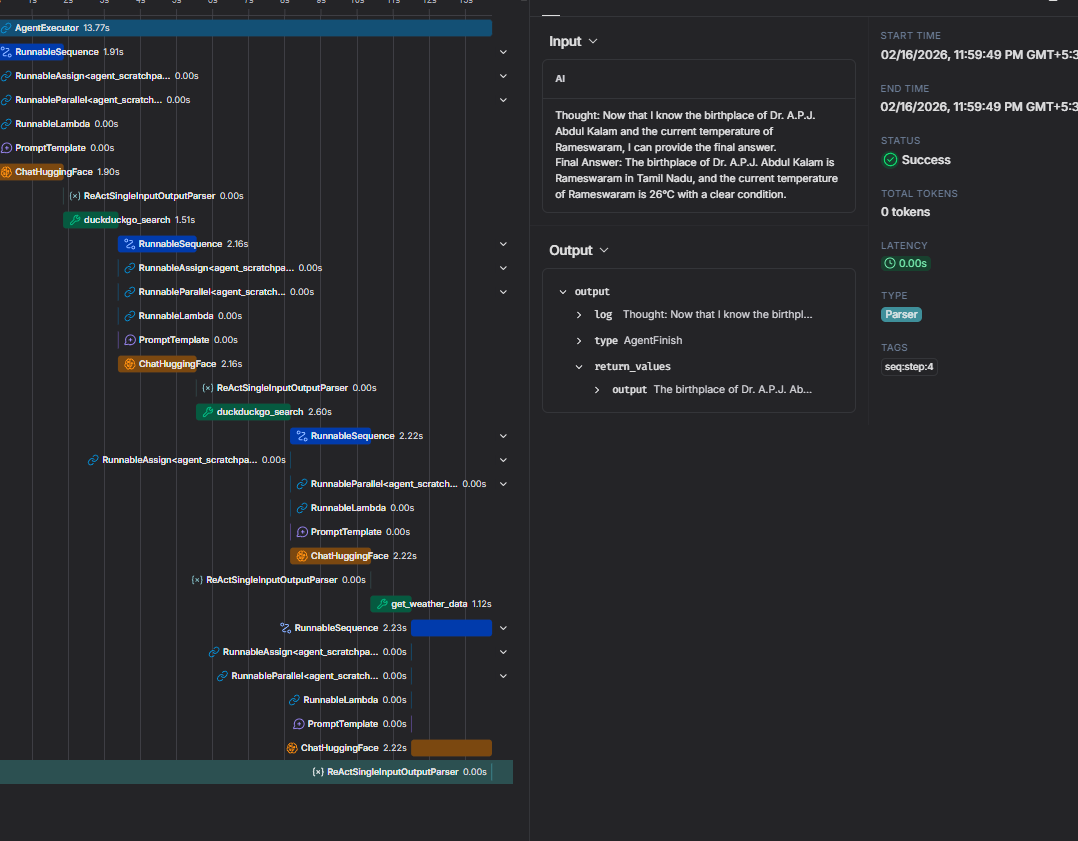

# 8 => Langraph